## Time Series Analysis

### Sunspot history monthly




---

In [1]:
# Load required libraries
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas import Grouper
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA


In [2]:
monthly_spots = pd.read_csv('monthly-sunspots.csv')

In [3]:
# Change to date-time
monthly_spots['Month'] = pd.to_datetime(monthly_spots['Month'])
monthly_spots.set_index('Month', inplace= True)
monthly_spots.head(20)

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
1749-06-01,83.5
1749-07-01,94.8
1749-08-01,66.3
1749-09-01,75.9


In [4]:
monthly_spots.describe()

,Sunspots
count,2820.000000
mean,51.265957
std,43.448971
min,0.000000
25%,15.700000
50%,42.000000
75%,74.925000
max,253.800000


In [5]:
monthly_spots.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2820 entries, 1749-01-01 to 1983-12-01
Data columns (total 1 columns):
Sunspots    2820 non-null float64
dtypes: float64(1)
memory usage: 44.1 KB


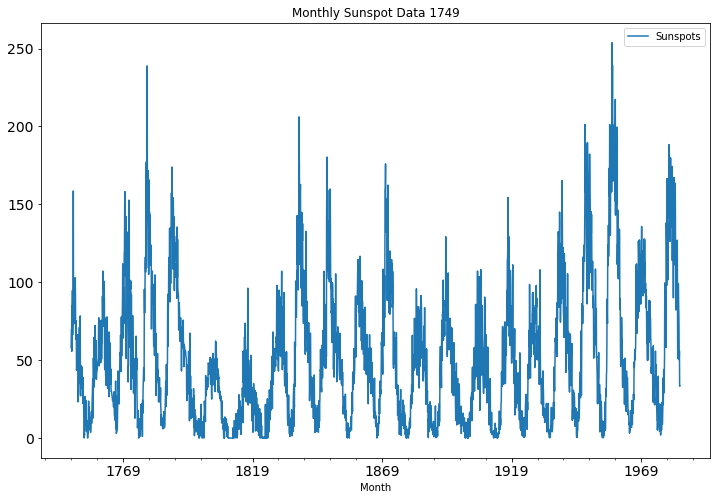

In [6]:
monthly_spots.plot(figsize=(12,8), title='Monthly Sunspot Data 1749', fontsize=14)

/Users/ericma/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


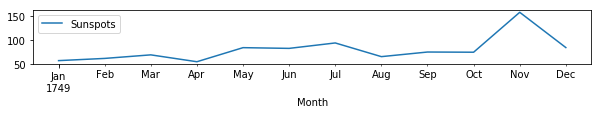

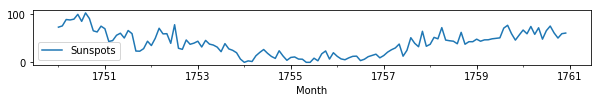

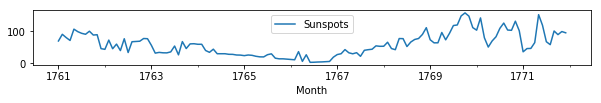

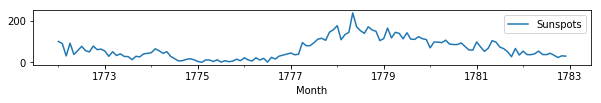

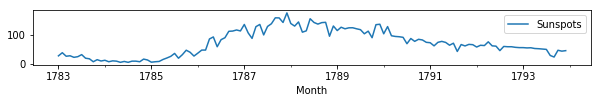

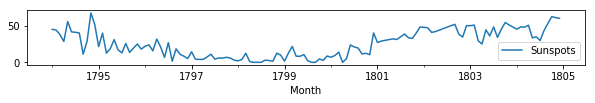

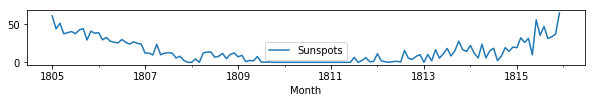

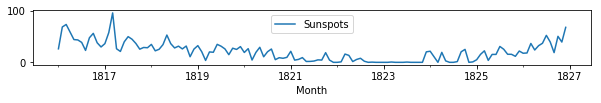

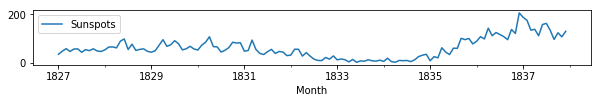

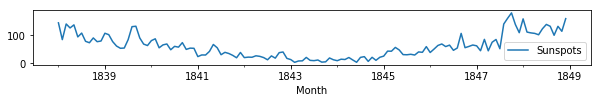

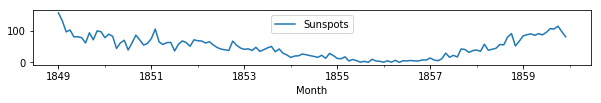

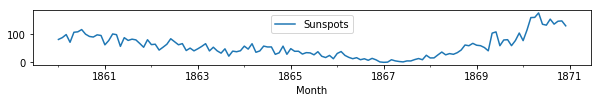

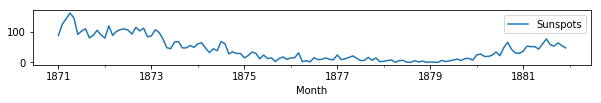

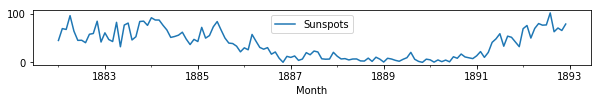

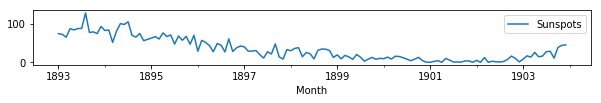

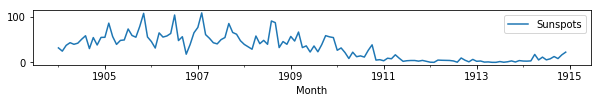

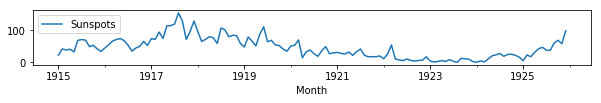

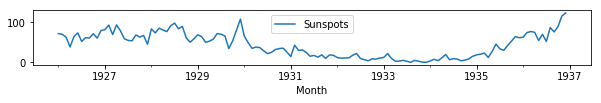

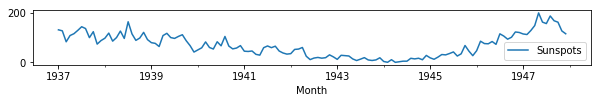

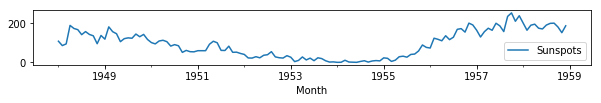

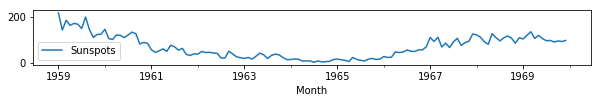

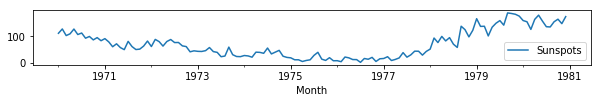

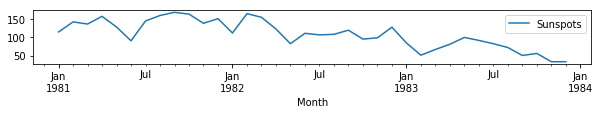

In [7]:
period_11y_group = monthly_spots.groupby(Grouper(freq='11A'))
period_11y_group.plot(figsize=(10,1));

In [12]:
# Credit Dmitriy Sergeev 
# https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [14]:
#create a function that will help us to quickly 
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    plotMovingAverage(timeseries, window, plot_intervals=True, scale=1.96, plot_anomalies=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -9.567668e+00
p-value                        2.333452e-16
#Lags Used                     2.700000e+01
Number of Observations Used    2.792000e+03
Critical Value (1%)           -3.432694e+00
Critical Value (5%)           -2.862576e+00
Critical Value (10%)          -2.567321e+00
dtype: float64


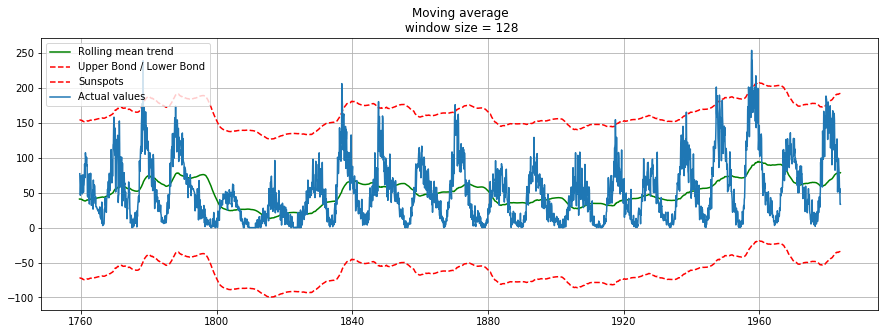

In [15]:
#test the stationarity of the untransformed dataset
test_stationarity(monthly_spots['Sunspots'], 128)

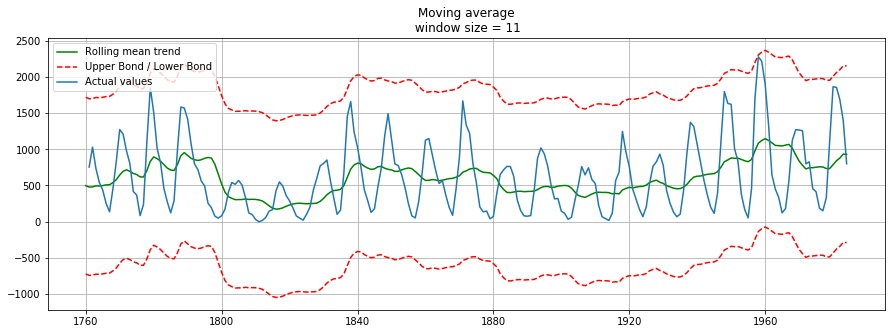

In [17]:
# Resample yearly
annual_spots = monthly_spots.resample('y').sum()
annual_spots = pd.DataFrame(annual_spots, columns=['Sunspots'])
# annual_spots.plot(figsize=(12,8), title= 'Annual Sunspots', fontsize=14)
plotMovingAverage(annual_spots, 11, plot_intervals=True, scale=1.96, plot_anomalies=False)

Results of Dickey-Fuller Test:
Test Statistic                -1.206146e+01
p-value                        2.463808e-22
#Lags Used                     7.000000e+00
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64


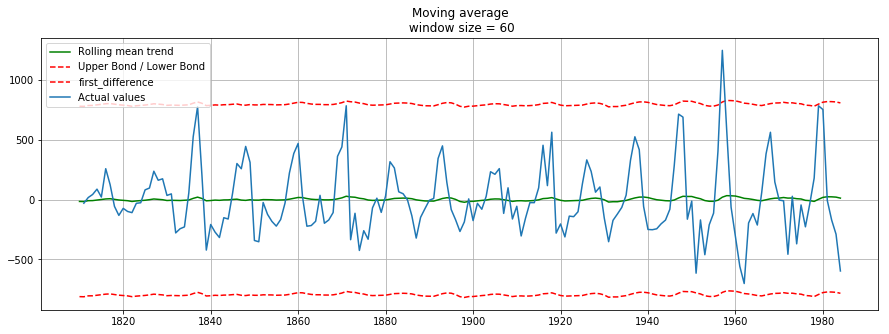

In [18]:
# First difference
annual_spots['first_difference'] = annual_spots['Sunspots'] - annual_spots['Sunspots'].shift(1)  
test_stationarity(annual_spots.first_difference.dropna(inplace=False), 60)

In [21]:
# Seasonal First difference
# annual_spots['seasonal_first_difference'] = annual_spots['Sunspots'] - annual_spots['Sunspots'].shift(132)
# test_stationarity(annual_spots.seasonal_first_difference.dropna(inplace=False), 132)

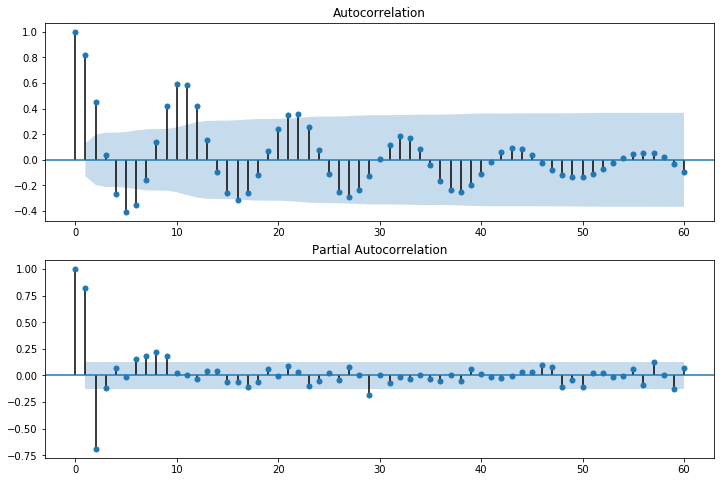

In [19]:
# ACF and PACF on original data
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(annual_spots['Sunspots'].iloc[1:], lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(annual_spots['Sunspots'].iloc[1:], lags=60, ax=ax2)

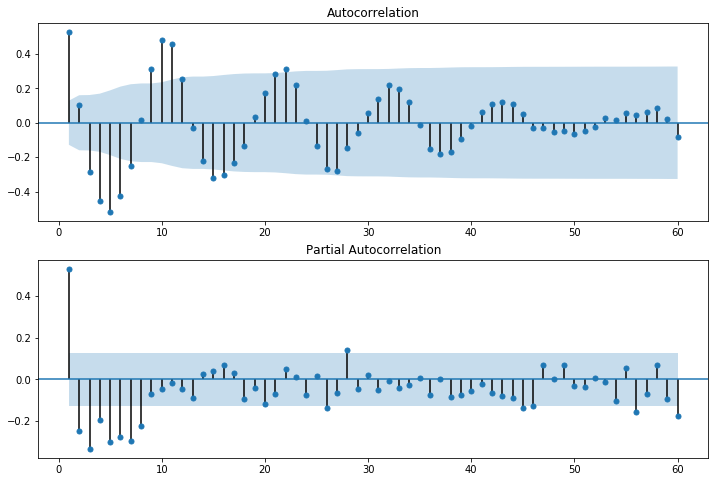

In [20]:
# ACF and PACF on first difference
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
# plot the ACF
fig = sm.graphics.tsa.plot_acf(annual_spots['first_difference'].iloc[1:], lags=60, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
# plot the PACF
fig = sm.graphics.tsa.plot_pacf(annual_spots['first_difference'].iloc[1:], lags=60, ax=ax2, zero=False)

In [21]:
annual_spots.head()
# annual_spots.dropna(inplace=True)

,Sunspots,first_difference
Month,,
1749-12-31,971.1,NaN
1750-12-31,1000.7,29.6
1751-12-31,571.9,-428.8
1752-12-31,573.6,1.7
1753-12-31,368.3,-205.3


In [22]:
# plotMovingAverage(annual_spots['Sunspots'].dropna(inplace=False), window=5, plot_intervals=True)

In [23]:
# plotMovingAverage(annual_spots['Sunspots'].dropna(inplace=False), window=22, plot_intervals=True)

<Figure size 432x288 with 0 Axes>

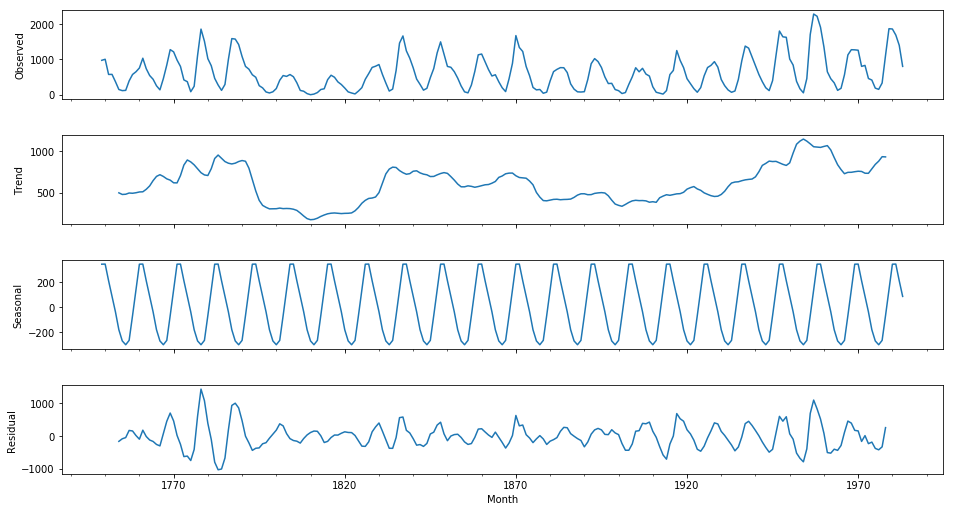

In [24]:
# Seasonal decompose with 128 mo years as period
decomposition_annual = seasonal_decompose(annual_spots['Sunspots'], freq=11)
fig = plt.figure()
fig = decomposition_annual.plot()
fig.set_size_inches(15, 8)

<Figure size 432x288 with 0 Axes>

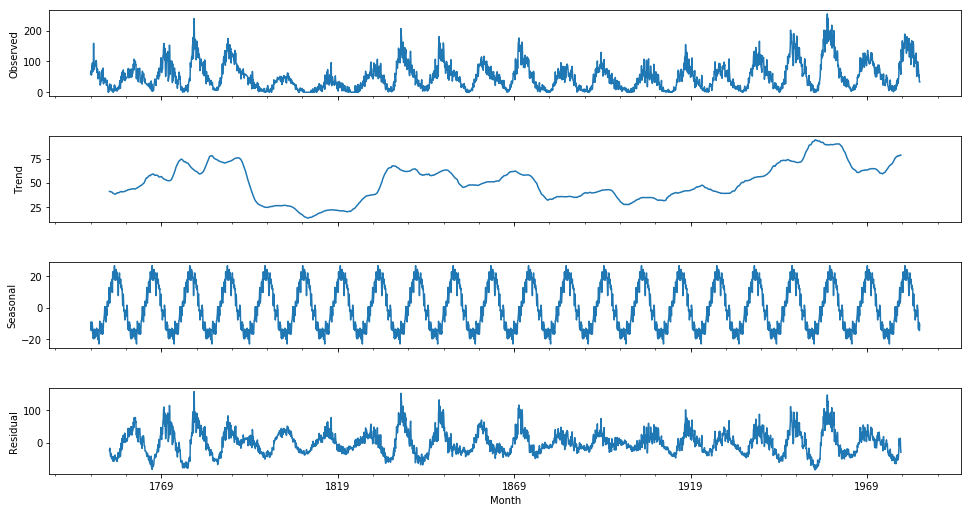

In [25]:
# Seasonal decompose with 11 years as period
decomposition_mo = seasonal_decompose(monthly_spots['Sunspots'], freq=128)
fig = plt.figure()
fig = decomposition_mo.plot()
fig.set_size_inches(15, 8)

In [26]:
train_mo = monthly_spots.copy()
train_yr = annual_spots.copy()

In [27]:
mo_spots_train = train_mo.iloc[:int(len(train_mo)*0.8)]
annual_spots_train = train_yr.iloc[:int(len(train_yr)*0.8)]
mo_spots_train.head()

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


In [28]:
annual_spots_train.head()

,Sunspots,first_difference
Month,,
1749-12-31,971.1,NaN
1750-12-31,1000.7,29.6
1751-12-31,571.9,-428.8
1752-12-31,573.6,1.7
1753-12-31,368.3,-205.3


In [33]:
# # Fit an ARMA model to yearly sampled data 
for p in range(6):
    for q in range(4):
        try:
            mod_arima = ARMA(annual_spots['Sunspots'], order=(p,q))
            res_arima = mod_arima.fit()
    # Print out summary information on the fit
            print('**************ARIMA p={}, d=0 ,q={}**************************************'.format(p, q))
            print(res_arima.summary())
            print()
        except:
            print()
            print("#####Noninvertable Error######")
            print()
            pass

/Users/ericma/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/ericma/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/ericma/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

**************ARIMA p=0, d=0 ,q=0**************************************
                              ARMA Model Results                              
Dep. Variable:               Sunspots   No. Observations:                  235
Model:                     ARMA(0, 0)   Log Likelihood               -1787.663
Method:                           css   S.D. of innovations            486.938
Date:                Tue, 16 Jul 2019   AIC                           3579.325
Time:                        09:23:56   BIC                           3586.245
Sample:                    12-31-1749   HQIC                          3582.115
                         - 12-31-1983                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        615.1915     31.764     19.367      0.000     552.935     677.448

**************ARIMA p=0, d=0 ,q=1*************************

**************ARIMA p=1, d=0 ,q=3**************************************
                              ARMA Model Results                              
Dep. Variable:               Sunspots   No. Observations:                  235
Model:                     ARMA(1, 3)   Log Likelihood               -1593.340
Method:                       css-mle   S.D. of innovations            212.011
Date:                Tue, 16 Jul 2019   AIC                           3198.679
Time:                        09:23:57   BIC                           3219.437
Sample:                    12-31-1749   HQIC                          3207.048
                         - 12-31-1983                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            613.5888     71.504      8.581      0.000     473.444     753.734
ar.L1.Sunspots     0.4759      0.092      5.189

**************ARIMA p=3, d=0 ,q=0**************************************
                              ARMA Model Results                              
Dep. Variable:               Sunspots   No. Observations:                  235
Model:                     ARMA(3, 0)   Log Likelihood               -1580.794
Method:                       css-mle   S.D. of innovations            200.863
Date:                Tue, 16 Jul 2019   AIC                           3171.587
Time:                        09:23:59   BIC                           3188.885
Sample:                    12-31-1749   HQIC                          3178.561
                         - 12-31-1983                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            608.7120     38.273     15.905      0.000     533.699     683.725
ar.L1.Sunspots     1.3011      0.065     20.093

**************ARIMA p=4, d=0 ,q=0**************************************
                              ARMA Model Results                              
Dep. Variable:               Sunspots   No. Observations:                  235
Model:                     ARMA(4, 0)   Log Likelihood               -1580.566
Method:                       css-mle   S.D. of innovations            200.666
Date:                Tue, 16 Jul 2019   AIC                           3173.131
Time:                        09:24:01   BIC                           3193.889
Sample:                    12-31-1749   HQIC                          3181.500
                         - 12-31-1983                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            609.2077     40.012     15.226      0.000     530.785     687.630
ar.L1.Sunspots     1.3060      0.065     20.065

**************ARIMA p=5, d=0 ,q=0**************************************
                              ARMA Model Results                              
Dep. Variable:               Sunspots   No. Observations:                  235
Model:                     ARMA(5, 0)   Log Likelihood               -1580.425
Method:                       css-mle   S.D. of innovations            200.542
Date:                Tue, 16 Jul 2019   AIC                           3174.849
Time:                        09:24:04   BIC                           3199.066
Sample:                    12-31-1749   HQIC                          3184.613
                         - 12-31-1983                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            608.7575     38.627     15.760      0.000     533.050     684.465
ar.L1.Sunspots     1.3076      0.065     20.081

In [34]:
# # Fit an ARIMA model to yearly sampled data 
for p in range(6):
    for q in range(4):
        try:
            mod_arima = ARIMA(annual_spots_train['Sunspots'], order=(p,1,q))
            res_arima = mod_arima.fit()
    # Print out summary information on the fit
            print('**************ARIMA p={}, d=1 ,q={}**************************************'.format(p, q))
            print(res_arima.summary())
            print()
        except:
            print()
            print("#####Noninvertable Error######")
            print()
            pass

/Users/ericma/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/ericma/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/ericma/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

**************ARIMA p=0, d=1 ,q=0**************************************
                             ARIMA Model Results                              
Dep. Variable:             D.Sunspots   No. Observations:                  187
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1301.688
Method:                           css   S.D. of innovations            255.177
Date:                Tue, 16 Jul 2019   AIC                           2607.375
Time:                        09:24:58   BIC                           2613.838
Sample:                    12-31-1750   HQIC                          2609.994
                         - 12-31-1936                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0765     18.660     -0.004      0.997     -36.650      36.497

**************ARIMA p=0, d=1 ,q=1*************************

**************ARIMA p=1, d=1 ,q=2**************************************
                             ARIMA Model Results                              
Dep. Variable:             D.Sunspots   No. Observations:                  187
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1264.200
Method:                       css-mle   S.D. of innovations            206.848
Date:                Tue, 16 Jul 2019   AIC                           2538.401
Time:                        09:24:59   BIC                           2554.556
Sample:                    12-31-1750   HQIC                          2544.947
                         - 12-31-1936                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.6344      1.408     -0.451      0.653      -3.394       2.125
ar.L1.D.Sunspots     0.7157      0.056   

**************ARIMA p=3, d=1 ,q=1**************************************
                             ARIMA Model Results                              
Dep. Variable:             D.Sunspots   No. Observations:                  187
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1239.281
Method:                       css-mle   S.D. of innovations            181.717
Date:                Tue, 16 Jul 2019   AIC                           2490.561
Time:                        09:25:00   BIC                           2509.948
Sample:                    12-31-1750   HQIC                          2498.417
                         - 12-31-1936                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1537      3.442     -0.045      0.964      -6.900       6.593
ar.L1.D.Sunspots     1.1891      0.081   

**************ARIMA p=5, d=1 ,q=1**************************************
                             ARIMA Model Results                              
Dep. Variable:             D.Sunspots   No. Observations:                  187
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -1233.650
Method:                       css-mle   S.D. of innovations            176.179
Date:                Tue, 16 Jul 2019   AIC                           2483.299
Time:                        09:25:02   BIC                           2509.148
Sample:                    12-31-1750   HQIC                          2493.773
                         - 12-31-1936                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2040      4.200      0.049      0.961      -8.028       8.436
ar.L1.D.Sunspots     1.0380      0.087   

In [35]:
# for p in range(4):
#     for q in range(4):
#         try:
#             mod_arima = ARIMA(annual_spots_train['first_difference'].dropna(inplace=False), order=(p,1,q))
#             res_arima = mod_arima.fit()
#     # Print out summary information on the fit
#             print('**************ARIMA p={}, d=1 ,q={}**************************************'.format(p, q))
#             print(res_arima.summary())
#             print()
#         except:
#             print()
#             print("########Noninvertable Error#########")
#             print()
#             pass

### Best ARIMA Hyperparameters ARIMA( 2, 1, 2 )

AIC = 2485.630

P>|z| const = 0.961

      AR L1, L2 = 0.00
      
      MA L1, L2 = 0.00

In [36]:
mod_arima = ARIMA(annual_spots_train['Sunspots'], order=(2,1,2))
res_arima_bestfit = mod_arima.fit()
# Print out summary information on the fit
print(res_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Sunspots   No. Observations:                  187
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -1232.363
Method:                       css-mle   S.D. of innovations            174.907
Date:                Tue, 16 Jul 2019   AIC                           2484.725
Time:                        09:27:29   BIC                           2517.036
Sample:                    12-31-1750   HQIC                          2497.818
                         - 12-31-1936                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3574      5.028      0.071      0.943      -9.497      10.212
ar.L1.D.Sunspots     1.1817      0.337      3.509      0.001       0.522       1.842
ar.L2.D.Sunspots    -0.3277 

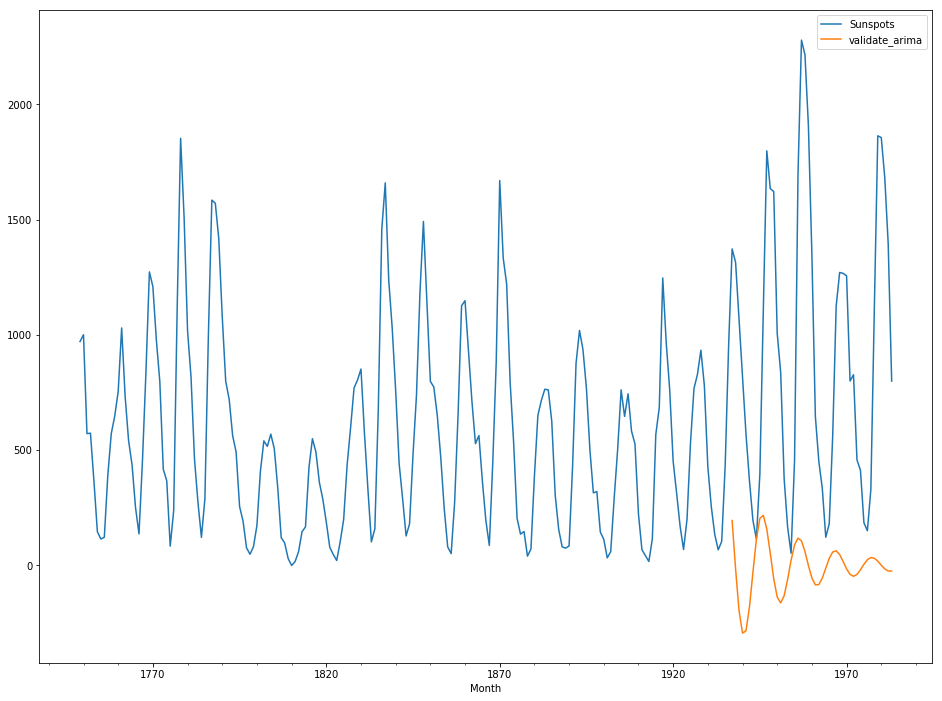

In [37]:
annual_spots['validate_arima'] = res_arima_bestfit.predict(start = int(len(annual_spots)*0.8), 
                                                           end= int(len(annual_spots)), 
                                                           dynamic= False)

annual_spots[['Sunspots', 'validate_arima']].plot(figsize=(16, 12)) 

In [ ]:
mod = sm.tsa.statespace.SARIMAX(mo_spots_train['Sunspots'], 
                                order=(1,0,2), 
                                seasonal_order=(2,1,2,132), 
                                enforce_invertibility=True)
res_sarimax = mod.fit()
print(res_sarimax.summary())

/Users/ericma/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
monthly_spots['validate_sarimax'] = res_sarimax.predict(start = int(len(monthly_spots)*0.8), 
                                                       end= int(len(monthly_spots)), 
                                                       dynamic= False)  
monthly_spots[['Sunspots', 'validate_sarimax']].plot(figsize=(16, 12)) 
plotMovingAverage(monthly_spots['validate_sarimax'].dropna(inplace=False), 11, plot_intervals=True, scale=1.96, plot_anomalies=False)

In [52]:
annual_spots_1 = annual_spots.copy()
annual_spots_1.dropna(inplace=True)

In [56]:
annual_spots_1.drop(['first_difference', 'validate_arima', 'validate_sarimax'],axis = 1, inplace = True)

In [59]:
mod = sm.tsa.statespace.SARIMAX(annual_spots_1['Sunspots'], 
                                order=(2,0,2), 
                                seasonal_order=(2,1,2,11), 
                                enforce_invertibility=True)
res_sarimax = mod.fit()


forecast = res_sarimax.forecast(len(annual_spots_1)+3)

ValueError: maxlag should be < nobs